In [2]:
import os
import datetime

# Initial Parameters
now = datetime.datetime.now()
str_datetime = str(now.year) + "_" + str(now.month) + "_" + str(now.day) + "_" + str(now.hour) + "_" + str(now.minute) + "_" + str(now.second)
working_directory = os.getcwd()

folder_dataset = "UTKFace"
#folder_dataset = "crop_part1"
path_dataset = working_directory + "\\resources\\" + folder_dataset

image_dimension = (96, 96, 3)
epochs = 100
lr = 1e-3
batch_size = 64 #1
test_size = 0.2
random_state = 42

data = []
labels_age = [] # Integer from 0 to 116
labels_gender = [] # 0=male, 1=female
labels_race = [] # 0 = denoting White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern).
num_classes_age = 117

In [3]:
import random

# Load image files from the dataset
image_files = os.listdir(path_dataset)
random.shuffle(image_files)
len(image_files)

23708

In [4]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

#DONT FORGET
#image_files = image_files[:50]

# Converting images to arrays and labelling
for image in image_files :

    image_read = cv2.imread(path_dataset + "\\" + image)
    image_read = cv2.resize(image_read, (image_dimension[0], image_dimension[1]))
    image_read = img_to_array(image_read)

    data.append(image_read)
    
    label_split = image.split("_")
    labels_age.append(label_split[0])
    labels_gender.append(label_split[1])
    labels_race.append(label_split[2])

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Normalize, rescale entries to lie in [0,1]
data = np.array(data, dtype="float") / 255.0
labels_age = np.array(labels_age)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels_age, test_size=test_size, random_state=random_state)

trainY = to_categorical(trainY, num_classes=num_classes_age)
testY = to_categorical(testY, num_classes=num_classes_age)

# Augmenting dataset 
data_generator = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Define face reader model
def build_model_face_reader(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if backend.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# Build model
model = build_model_face_reader(width=image_dimension[0], height=image_dimension[1], depth=image_dimension[2], classes=num_classes_age)

In [7]:
from tensorflow.keras.optimizers import Adam

# Compile the model
optimizer = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]) #categorical_crossentropy

# Train the model
H = model.fit_generator(data_generator.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size, epochs = epochs, verbose=1)

# save the model to disk
model.save("resources/models/" + str_datetime + "_face_reader.model")

Epoch 1/100
40/40 [==============================] - 4s 81ms/step - loss: 0.6443 - accuracy: 0.0000e+00 - val_loss: 0.3748 - val_accuracy: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 2s 58ms/step - loss: 0.2148 - accuracy: 0.0000e+00 - val_loss: 0.1047 - val_accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 2s 57ms/step - loss: 0.0567 - accuracy: 0.0075 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 2s 58ms/step - loss: 0.0465 - accuracy: 0.0969 - val_loss: 0.1024 - val_accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 2s 57ms/step - loss: 0.0432 - accuracy: 0.0237 - val_loss: 0.1105 - val_accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 2s 59ms/step - loss: 0.0411 - accuracy: 0.2008 - val_loss: 0.1298 - val_accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 2s 54ms/step - loss: 0.0414 - accuracy: 0.0447 - val_loss: 0.18

KeyboardInterrupt: 

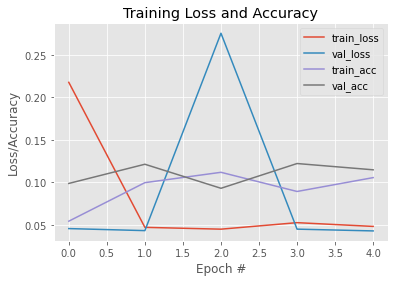

In [47]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save plot to disk
plt.savefig('plot.png')